In [1]:
import sys
sys.path.append('../')

import os
import re
import json
import click
import torch
import dnnlib
from torch_utils import distributed as dist
from training import training_loop

import matplotlib.pyplot as plt
import h5py
import numpy as np

# 2D UNet using EDM2

In [2]:
img_resolution = 32
img_channels = 1
label_dim = 0
model_channels = 128
dropout = 0.0


network_kwargs = dnnlib.EasyDict(class_name='training.networks_edm2.Precond', model_channels=model_channels, dropout=dropout)
network_kwargs.use_fp16 = False
interface_kwargs = dict(img_resolution=img_resolution, img_channels=img_channels, label_dim=label_dim)
net = dnnlib.util.construct_class_by_name(**network_kwargs, **interface_kwargs)


In [3]:
net.cuda()

Precond(
  (unet): UNet(
    (emb_fourier): MPFourier()
    (emb_noise): MPConv()
    (enc): ModuleDict(
      (32x32_conv): MPConv()
      (32x32_block0): Block(
        (conv_res0): MPConv()
        (emb_linear): MPConv()
        (conv_res1): MPConv()
      )
      (32x32_block1): Block(
        (conv_res0): MPConv()
        (emb_linear): MPConv()
        (conv_res1): MPConv()
      )
      (32x32_block2): Block(
        (conv_res0): MPConv()
        (emb_linear): MPConv()
        (conv_res1): MPConv()
      )
      (16x16_down): Block(
        (conv_res0): MPConv()
        (emb_linear): MPConv()
        (conv_res1): MPConv()
      )
      (16x16_block0): Block(
        (conv_res0): MPConv()
        (emb_linear): MPConv()
        (conv_res1): MPConv()
        (conv_skip): MPConv()
        (attn_qkv): MPConv()
        (attn_proj): MPConv()
      )
      (16x16_block1): Block(
        (conv_res0): MPConv()
        (emb_linear): MPConv()
        (conv_res1): MPConv()
        (attn_qkv):

In [4]:
param_size = 0
for param in net.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in net.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))

model size: 452.766MB


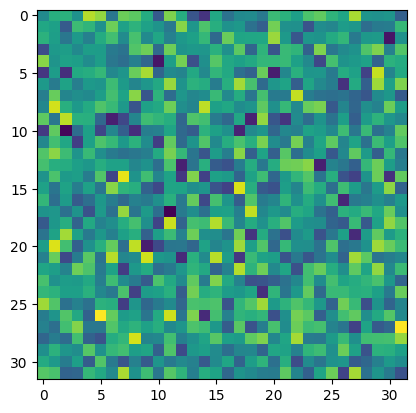

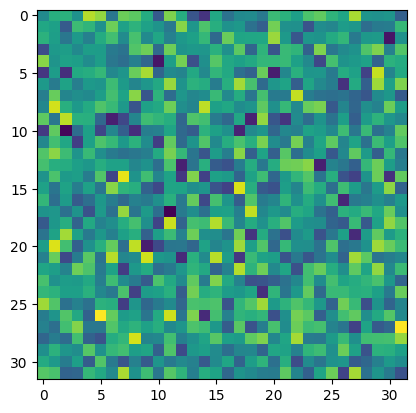

In [5]:
latent = torch.randn(4, img_channels, img_resolution, img_resolution).cuda()

output = net(latent, 1*torch.ones((1,1,1,1)).cuda())

plt.imshow(output[0].detach().cpu().permute(1,2,0).numpy())
plt.show()
plt.imshow(latent[0].detach().cpu().permute(1,2,0).numpy())

# 3D UNet using EDM2

In [6]:
img_resolution = 16
temporal_resolution = 16
img_channels = 1
label_dim = 10
model_channels = 128
dropout = 0.0
unet = '3D'


network_kwargs = dnnlib.EasyDict(class_name='training.networks3D_edm2.Precond3D', model_channels=model_channels, dropout=dropout,)
network_kwargs.use_fp16 = False
interface_kwargs = dict(img_resolution=img_resolution, temporal_resolution=temporal_resolution, img_channels=img_channels, label_dim=label_dim, unet=unet, channel_mult=[1,2,2,2], attn_resolutions=[4])
net = dnnlib.util.construct_class_by_name(**network_kwargs, **interface_kwargs)


In [7]:
net.cuda()

Precond3D(
  (unet): UNet3D(
    (emb_fourier): MPFourier()
    (emb_noise): MPConv3D()
    (emb_label): MPConv3D()
    (enc): ModuleDict(
      (16x16x16_conv): MPConv3D()
      (16x16x16_block0): Block3D(
        (conv_res0): MPConv3D()
        (emb_linear): MPConv3D()
        (conv_res1): MPConv3D()
      )
      (16x16x16_block1): Block3D(
        (conv_res0): MPConv3D()
        (emb_linear): MPConv3D()
        (conv_res1): MPConv3D()
      )
      (16x16x16_block2): Block3D(
        (conv_res0): MPConv3D()
        (emb_linear): MPConv3D()
        (conv_res1): MPConv3D()
      )
      (8x8x8_down): Block3D(
        (conv_res0): MPConv3D()
        (emb_linear): MPConv3D()
        (conv_res1): MPConv3D()
      )
      (8x8x8_block0): Block3D(
        (conv_res0): MPConv3D()
        (emb_linear): MPConv3D()
        (conv_res1): MPConv3D()
        (conv_skip): MPConv3D()
      )
      (8x8x8_block1): Block3D(
        (conv_res0): MPConv3D()
        (emb_linear): MPConv3D()
        (con

In [8]:
param_size = 0
for param in net.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in net.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))

model size: 513.802MB


torch.Size([4, 1, 16, 16, 16])


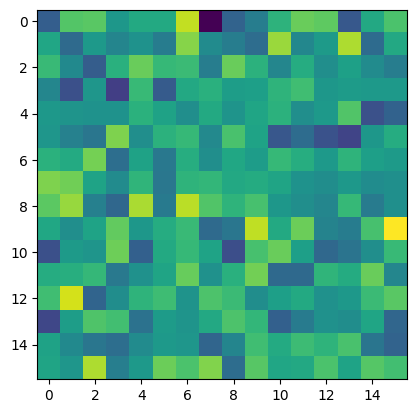

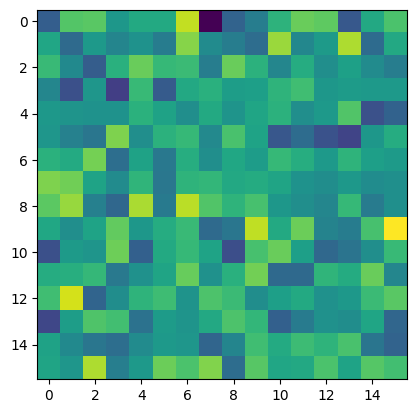

In [9]:
latent = torch.randn(4, img_channels, temporal_resolution, img_resolution, img_resolution).cuda()
label = torch.randn(4, label_dim, 1, 1, 1).cuda()

output = net(latent, sigma=1*torch.ones((1,1,1,1)).cuda(), class_labels=label)
print(output.shape)

plt.imshow(output[0,:,0].detach().cpu().permute(1,2,0).numpy())
plt.show()
plt.imshow(latent[0,:,0].detach().cpu().permute(1,2,0).numpy())

# 2D+1D UNet using EDM2

In [10]:
img_resolution = 16
temporal_resolution = 16
img_channels = 1
label_dim = 10
model_channels = 128
dropout = 0.0
unet = '2D1D'

network_kwargs = dnnlib.EasyDict(class_name='training.networks3D_edm2.Precond3D', model_channels=model_channels, dropout=dropout)
network_kwargs.use_fp16 = False
interface_kwargs = dict(img_resolution=img_resolution, temporal_resolution=temporal_resolution, img_channels=img_channels, label_dim=label_dim, unet=unet, channel_mult=[1,2,2,2], attn_resolutions=[4])
net = dnnlib.util.construct_class_by_name(**network_kwargs, **interface_kwargs)


In [11]:
net.cuda()

Precond3D(
  (unet): UNet2D1D(
    (emb_fourier): MPFourier()
    (emb_noise): MPConv3D()
    (emb_label): MPConv3D()
    (enc): ModuleDict(
      (16x16x16_conv): MPConv3D()
      (16x16x16_block0): Block2D1D(
        (conv_res0_spatial): MPConv3D()
        (conv_res0_temporal): MPConv3D()
        (emb_linear): MPConv3D()
        (conv_res1_spatial): MPConv3D()
        (conv_res1_temporal): MPConv3D()
      )
      (16x16x16_block1): Block2D1D(
        (conv_res0_spatial): MPConv3D()
        (conv_res0_temporal): MPConv3D()
        (emb_linear): MPConv3D()
        (conv_res1_spatial): MPConv3D()
        (conv_res1_temporal): MPConv3D()
      )
      (16x16x16_block2): Block2D1D(
        (conv_res0_spatial): MPConv3D()
        (conv_res0_temporal): MPConv3D()
        (emb_linear): MPConv3D()
        (conv_res1_spatial): MPConv3D()
        (conv_res1_temporal): MPConv3D()
      )
      (8x8x8_down): Block2D1D(
        (conv_res0_spatial): MPConv3D()
        (conv_res0_temporal): MPConv3

In [12]:
param_size = 0
for param in net.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in net.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))

model size: 231.401MB


torch.Size([4, 1, 16, 16, 16])


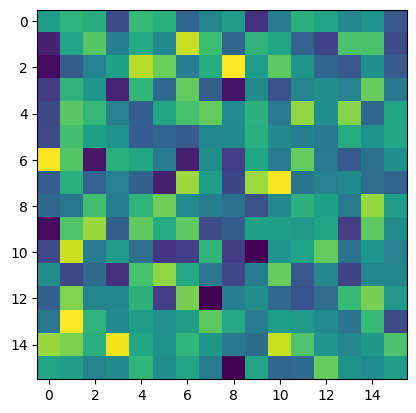

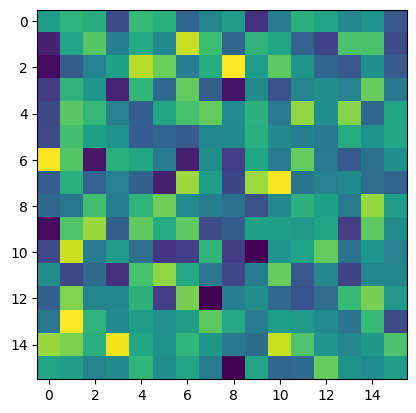

In [13]:
latent = torch.randn(4, img_channels, temporal_resolution, img_resolution, img_resolution).cuda()
label = torch.randn(4, label_dim, 1, 1, 1).cuda()

output = net(latent, sigma=1*torch.ones((1,1,1,1)).cuda(), class_labels=label)
print(output.shape)






plt.imshow(output[0,:,0].detach().cpu().permute(1,2,0).numpy())
plt.show()
plt.imshow(latent[0,:,0].detach().cpu().permute(1,2,0).numpy())

# Crafting a test dataset

In [14]:
# f = h5py.File('../data/mnist3d/full_dataset_vectors.h5', 'r')
f = h5py.File('/home/trevor/trevor/repos/3D_SR_CT/data/mnist3d/mnist_dataset.h5', 'r')

train_data = np.array(f['X_train']).reshape(-1, 16, 16, 16)[:,np.newaxis,:,:,:]
train_labels = np.array(f['y_train'])

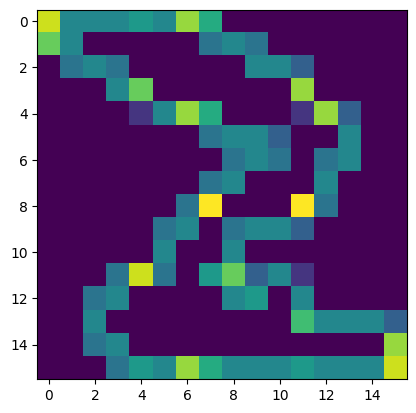

In [15]:
plt.imshow(train_data[0][0,:,:,8])

In [17]:
class MnistDataset(torch.utils.data.Dataset):
    def __init__(self,
        name,                   # Name of the dataset.
        data,                   # Image data as a numpy array (NCTHW).
        labels,                 # Labels as a numpy array (N).
        raw_shape,              # Shape of the raw image data (NCTHW).
        use_labels  = True,     # Enable conditioning labels? False = label dimension is zero.
        # max_size    = None,     # Artificially limit the size of the dataset. None = no limit. Applied before xflip.
        # xflip       = False,    # Artificially double the size of the dataset via x-flips. Applied after max_size.
        random_seed = 0,        # Random seed to use when applying max_size.
        cache       = False,    # Cache images in CPU memory?
    ):
        self._name = name
        self._raw_shape = list(raw_shape)
        self._use_labels = use_labels
        self._cache = cache
        self._cached_images = dict() # {raw_idx: np.ndarray, ...}
        self._raw_labels = None
        self._label_shape = None
        
        self.data = data
        self.labels = labels
        self.size = data.shape[0]

        self._raw_idx = np.arange(self._raw_shape[0], dtype=np.int64)
        
        # # Apply max_size.
        # if (max_size is not None) and (self._raw_idx.size > max_size):
        #     np.random.RandomState(random_seed % (1 << 31)).shuffle(self._raw_idx)
        #     self._raw_idx = np.sort(self._raw_idx[:max_size])

        # # Apply xflip.
        # self._xflip = np.zeros(self._raw_idx.size, dtype=np.uint8)
        # if xflip:
        #     self._raw_idx = np.tile(self._raw_idx, 2)
        #     self._xflip = np.concatenate([self._xflip, np.ones_like(self._xflip)])

    def _get_raw_labels(self):
        if self._raw_labels is None:
            self._raw_labels = self._load_raw_labels() if self._use_labels else None
            if self._raw_labels is None:
                self._raw_labels = np.zeros([self._raw_shape[0], 0], dtype=np.float32)
            assert isinstance(self._raw_labels, np.ndarray)
            assert self._raw_labels.shape[0] == self._raw_shape[0]
            assert self._raw_labels.dtype in [np.float32, np.int64]
            if self._raw_labels.dtype == np.int64:
                assert self._raw_labels.ndim == 1
                assert np.all(self._raw_labels >= 0)
        return self._raw_labels

    def close(self): # to be overridden by subclass
        pass

    def _load_raw_image(self, raw_idx): # to be overridden by subclass
        return self.data[raw_idx]

    def _load_raw_labels(self): # to be overridden by subclass
        return self.labels

    def __getstate__(self):
        return dict(self.__dict__, _raw_labels=None)

    def __del__(self):
        try:
            self.close()
        except:
            pass

    def __len__(self):
        return self._raw_idx.size

    def __getitem__(self, idx):
        raw_idx = self._raw_idx[idx]
        image = self._cached_images.get(raw_idx, None)
        if image is None:
            image = self._load_raw_image(raw_idx)
            if self._cache:
                self._cached_images[raw_idx] = image
        assert isinstance(image, np.ndarray)
        assert list(image.shape) == self._raw_shape[1:]
        # if self._xflip[idx]:
        #     assert image.ndim == 3 # CHW
        #     image = image[:, :, ::-1]
        return image.copy(), self.get_label(idx)

    def get_label(self, idx):
        label = self._get_raw_labels()[self._raw_idx[idx]]
        if label.dtype == np.int64:
            onehot = np.zeros(self.label_shape, dtype=np.float32)
            onehot[label] = 1
            label = onehot
        return label.copy()

    def get_details(self, idx):
        d = dnnlib.EasyDict()
        d.raw_idx = int(self._raw_idx[idx])
        # d.xflip = (int(self._xflip[idx]) != 0)
        d.raw_label = self._get_raw_labels()[d.raw_idx].copy()
        return d

    @property
    def name(self):
        return self._name

    @property
    def image_shape(self): # [CTHW]
        return list(self._raw_shape[1:])

    @property
    def num_channels(self):
        # assert len(self.image_shape) == 3 # CTHW
        return self.image_shape[0]

    @property
    def resolution(self):
        assert len(self.image_shape) == 3 # CTHW
        assert self.image_shape[2] == self.image_shape[3]
        return self.image_shape[2]

    @property
    def label_shape(self):
        if self._label_shape is None:
            raw_labels = self._get_raw_labels()
            if raw_labels.dtype == np.int64:
                self._label_shape = [int(np.max(raw_labels)) + 1]
            else:
                self._label_shape = raw_labels.shape[1:]
        return list(self._label_shape)

    @property
    def label_dim(self):
        assert len(self.label_shape) == 1
        return self.label_shape[0]

    @property
    def has_labels(self):
        return any(x != 0 for x in self.label_shape)

    @property
    def has_onehot_labels(self):
        return self._get_raw_labels().dtype == np.int64

In [18]:
training_dataset = MnistDataset('mnist_test', train_data, train_labels, train_data.shape)

# Training a model

In [19]:
# Copyright (c) 2024, NVIDIA CORPORATION & AFFILIATES. All rights reserved.
#
# This work is licensed under a Creative Commons
# Attribution-NonCommercial-ShareAlike 4.0 International License.
# You should have received a copy of the license along with this
# work. If not, see http://creativecommons.org/licenses/by-nc-sa/4.0/

"""Main training loop."""

import os
import time
import copy
import pickle
import psutil
import numpy as np
import torch
import dnnlib
from torch_utils import distributed as dist
from torch_utils import training_stats
from torch_utils import persistence
from torch_utils import misc
import shutil

#----------------------------------------------------------------------------
# Uncertainty-based loss function (Equations 14,15,16,21) proposed in the
# paper "Analyzing and Improving the Training Dynamics of Diffusion Models".

# @persistence.persistent_class
class EDM2Loss:
    def __init__(self, P_mean=-0.4, P_std=1.0, sigma_data=0.5):
        self.P_mean = P_mean
        self.P_std = P_std
        self.sigma_data = sigma_data

    def __call__(self, net, images, labels=None):
        rnd_normal = torch.randn([images.shape[0], 1, 1, 1, 1], device=images.device)
        sigma = (rnd_normal * self.P_std + self.P_mean).exp()
        weight = (sigma ** 2 + self.sigma_data ** 2) / (sigma * self.sigma_data) ** 2
        noise = torch.randn_like(images) * sigma
        denoised, logvar = net(images + noise, sigma, labels, return_logvar=True)
        loss = (weight / logvar.exp()) * ((denoised - images) ** 2) + logvar
        return loss

#----------------------------------------------------------------------------
# Learning rate decay schedule used in the paper "Analyzing and Improving
# the Training Dynamics of Diffusion Models".

def learning_rate_schedule(cur_nimg, batch_size, ref_lr=100e-4, ref_batches=70e3, rampup_Mimg=10):
    lr = ref_lr
    if ref_batches > 0:
        lr /= np.sqrt(max(cur_nimg / (ref_batches * batch_size), 1))
    if rampup_Mimg > 0:
        lr *= min(cur_nimg / (rampup_Mimg * 1e6), 1)
    return lr

#----------------------------------------------------------------------------
# EDM sampler from the paper
# "Elucidating the Design Space of Diffusion-Based Generative Models",
# extended to support classifier-free guidance.

def edm_sampler(
    net, noise, labels=None, gnet=None,
    num_steps=32, sigma_min=0.002, sigma_max=80, rho=7, guidance=1,
    S_churn=0, S_min=0, S_max=float('inf'), S_noise=1,
    dtype=torch.float32, randn_like=torch.randn_like,
):
    # Guided denoiser.
    def denoise(x, t):
        Dx = net(x, t, labels).to(dtype)
        if guidance == 1:
            return Dx
        ref_Dx = gnet(x, t).to(dtype)
        return ref_Dx.lerp(Dx, guidance)

    # Time step discretization.
    step_indices = torch.arange(num_steps, dtype=dtype, device=noise.device)
    t_steps = (sigma_max ** (1 / rho) + step_indices / (num_steps - 1) * (sigma_min ** (1 / rho) - sigma_max ** (1 / rho))) ** rho
    t_steps = torch.cat([t_steps, torch.zeros_like(t_steps[:1])]) # t_N = 0

    # Main sampling loop.
    x_next = noise.to(dtype) * t_steps[0]
    for i, (t_cur, t_next) in enumerate(zip(t_steps[:-1], t_steps[1:])): # 0, ..., N-1
        x_cur = x_next

        # Increase noise temporarily.
        if S_churn > 0 and S_min <= t_cur <= S_max:
            gamma = min(S_churn / num_steps, np.sqrt(2) - 1)
            t_hat = t_cur + gamma * t_cur
            x_hat = x_cur + (t_hat ** 2 - t_cur ** 2).sqrt() * S_noise * randn_like(x_cur)
        else:
            t_hat = t_cur
            x_hat = x_cur

        # Euler step.
        d_cur = (x_hat - denoise(x_hat, t_hat)) / t_hat
        x_next = x_hat + (t_next - t_hat) * d_cur

        # Apply 2nd order correction.
        if i < num_steps - 1:
            d_prime = (x_next - denoise(x_next, t_next)) / t_next
            x_next = x_hat + (t_next - t_hat) * (0.5 * d_cur + 0.5 * d_prime)

    return x_next

In [20]:
loss_fn = EDM2Loss(P_mean=-0.4, P_std=1.0, sigma_data=0.5)

In [24]:
os.makedirs('../experiments/mnist_test', exist_ok=True)

In [27]:

dataset_kwargs      = None
data_loader_kwargs  = dict(class_name='torch.utils.data.DataLoader', pin_memory=True, num_workers=2, prefetch_factor=2)
network_kwargs      = dict(class_name='training.networks_edm2.Precond')
loss_kwargs         = dict(class_name='training.training_loop.EDM2Loss')
optimizer_kwargs    = dict(class_name='torch.optim.Adam', betas=(0.9, 0.99))
lr_kwargs           = dict(func_name='training.training_loop.learning_rate_schedule')
ema_kwargs          = dict(class_name='training.phema.PowerFunctionEMA')

run_dir             = '../experiments/mnist_test'      # Output directory.
seed                = 0        # Global random seed.
batch_size          = 16        # Total batch size for one training iteration.
batch_gpu           = None     # Limit batch size per GPU. None = no limit.
total_nimg          = 8<<30    # Train for a total of N training images.
slice_nimg          = None     # Train for a maximum of N training images in one invocation. None = no limit.
status_nimg         = 128<<8  # Report status every N training images. None = disable.
snapshot_nimg       = 8<<16    # Save network snapshot every N training images. None = disable.
checkpoint_nimg     = 128<<16  # Save state checkpoint every N training images. None = disable.

loss_scaling        = 1        # Loss scaling factor for reducing FP16 under/overflows.
force_finite        = True     # Get rid of NaN/Inf gradients before feeding them to the optimizer.
cudnn_benchmark     = True     # Enable torch.backends.cudnn.benchmark?
device              = torch.device('cuda')

if os.path.exists(f'{run_dir}/'):
    shutil.rmtree(run_dir)
    os.makedirs(f'{run_dir}/')

# Initialize.
prev_status_time = time.time()
misc.set_random_seed(seed, dist.get_rank())
# torch.backends.cudnn.benchmark = cudnn_benchmark
torch.backends.cudnn.allow_tf32 = False
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cuda.matmul.allow_fp16_reduced_precision_reduction = False

# Validate batch size.
batch_gpu_total = batch_size // dist.get_world_size()
if batch_gpu is None or batch_gpu > batch_gpu_total:
    batch_gpu = batch_gpu_total
num_accumulation_rounds = batch_gpu_total // batch_gpu
assert batch_size == batch_gpu * num_accumulation_rounds * dist.get_world_size()
assert total_nimg % batch_size == 0
assert slice_nimg is None or slice_nimg % batch_size == 0
assert status_nimg is None or status_nimg % batch_size == 0
assert snapshot_nimg is None or (snapshot_nimg % batch_size == 0 and snapshot_nimg % 1024 == 0)
assert checkpoint_nimg is None or (checkpoint_nimg % batch_size == 0 and checkpoint_nimg % 1024 == 0)

# Setup dataset, and network.
dist.print0('Loading dataset...')
# Pass in training dataset object.
dataset_obj = training_dataset

ref_image, ref_label = dataset_obj[0]
dist.print0('Constructing network...')
interface_kwargs = dict(img_resolution=ref_image.shape[-1], img_channels=ref_image.shape[1], label_dim=ref_label.shape[-1])
# Pass in network object.
net = net
net.train().requires_grad_(True).to(device)

# Print network summary.
if dist.get_rank() == 0:
    misc.print_module_summary(net, [
        torch.zeros([batch_gpu, net.img_channels, net.temporal_resolution, net.img_resolution, net.img_resolution], device=device), # ------------------------need to alter dimensions of module summary input--------------------------------
        torch.ones([batch_gpu], device=device),
        torch.zeros([batch_gpu, net.label_dim], device=device),
    ], max_nesting=2)

# Setup training state.
dist.print0('Setting up training state...')
state = dnnlib.EasyDict(cur_nimg=0, total_elapsed_time=0)
# ddp = torch.nn.parallel.DistributedDataParallel(net, device_ids=[device])
# loss_fn = dnnlib.util.construct_class_by_name(**loss_kwargs)
loss_fn = loss_fn
optimizer = dnnlib.util.construct_class_by_name(params=net.parameters(), **optimizer_kwargs)
ema = dnnlib.util.construct_class_by_name(net=net, **ema_kwargs) if ema_kwargs is not None else None

# Load previous checkpoint and decide how long to train.
checkpoint = dist.CheckpointIO(state=state, net=net, loss_fn=loss_fn, optimizer=optimizer, ema=ema)
checkpoint.load_latest(run_dir)
stop_at_nimg = total_nimg
if slice_nimg is not None:
    granularity = checkpoint_nimg if checkpoint_nimg is not None else snapshot_nimg if snapshot_nimg is not None else batch_size
    slice_end_nimg = (state.cur_nimg + slice_nimg) // granularity * granularity # round down
    stop_at_nimg = min(stop_at_nimg, slice_end_nimg)
assert stop_at_nimg > state.cur_nimg
dist.print0(f'Training from {state.cur_nimg // 1000} kimg to {stop_at_nimg // 1000} kimg:')
dist.print0()

# Main training loop.
dataset_sampler = misc.InfiniteSampler(dataset=dataset_obj, rank=dist.get_rank(), num_replicas=dist.get_world_size(), seed=seed, start_idx=state.cur_nimg)
dataset_iterator = iter(dnnlib.util.construct_class_by_name(dataset=dataset_obj, sampler=dataset_sampler, batch_size=batch_gpu, **data_loader_kwargs))
prev_status_nimg = state.cur_nimg
cumulative_training_time = 0
start_nimg = state.cur_nimg
stats_jsonl = None
while True:
    done = (state.cur_nimg >= stop_at_nimg)

    # Report status.
    if status_nimg is not None and (done or state.cur_nimg % status_nimg == 0) and (state.cur_nimg != start_nimg or start_nimg == 0):
        cur_time = time.time()
        state.total_elapsed_time += cur_time - prev_status_time
        cur_process = psutil.Process(os.getpid())
        cpu_memory_usage = sum(p.memory_info().rss for p in [cur_process] + cur_process.children(recursive=True))
        dist.print0(' '.join(['Status:',
            'kimg',         f"{training_stats.report0('Progress/kimg',                              state.cur_nimg / 1e3):<9.1f}",
            'time',         f"{dnnlib.util.format_time(training_stats.report0('Timing/total_sec',   state.total_elapsed_time)):<12s}",
            'sec/tick',     f"{training_stats.report0('Timing/sec_per_tick',                        cur_time - prev_status_time):<8.2f}",
            'sec/kimg',     f"{training_stats.report0('Timing/sec_per_kimg',                        cumulative_training_time / max(state.cur_nimg - prev_status_nimg, 1) * 1e3):<7.3f}",
            'maintenance',  f"{training_stats.report0('Timing/maintenance_sec',                     cur_time - prev_status_time - cumulative_training_time):<7.2f}",
            'cpumem',       f"{training_stats.report0('Resources/cpu_mem_gb',                       cpu_memory_usage / 2**30):<6.2f}",
            'gpumem',       f"{training_stats.report0('Resources/peak_gpu_mem_gb',                  torch.cuda.max_memory_allocated(device) / 2**30):<6.2f}",
            'reserved',     f"{training_stats.report0('Resources/peak_gpu_mem_reserved_gb',         torch.cuda.max_memory_reserved(device) / 2**30):<6.2f}",
        ]))
        cumulative_training_time = 0
        prev_status_nimg = state.cur_nimg
        prev_status_time = cur_time
        torch.cuda.reset_peak_memory_stats()

        # Flush training stats.
        training_stats.default_collector.update()
        if dist.get_rank() == 0:
            if stats_jsonl is None:
                stats_jsonl = open(os.path.join(run_dir, 'stats.jsonl'), 'at')
            fmt = {'Progress/tick': '%.0f', 'Progress/kimg': '%.3f', 'timestamp': '%.3f'}
            items = [(name, value.mean) for name, value in training_stats.default_collector.as_dict().items()] + [('timestamp', time.time())]
            items = [f'"{name}": ' + (fmt.get(name, '%g') % value if np.isfinite(value) else 'NaN') for name, value in items]
            stats_jsonl.write('{' + ', '.join(items) + '}\n')
            stats_jsonl.flush()

        # Update progress and check for abort.
        dist.update_progress(state.cur_nimg // 1000, stop_at_nimg // 1000)
        if state.cur_nimg == stop_at_nimg and state.cur_nimg < total_nimg:
            dist.request_suspend()
        if dist.should_stop() or dist.should_suspend():
            done = True
            
        # Validate.
        with torch.no_grad():
            net.eval()
            noise = torch.randn([1, net.img_channels, net.temporal_resolution, net.img_resolution, net.img_resolution], device=device)
            labels = torch.eye(net.label_dim, device=device)[torch.randint(net.label_dim, size=[1], device=device)]
            samples = edm_sampler(net, noise, labels=labels, num_steps=32, sigma_min=0.002, sigma_max=80, rho=7, guidance=1,
                        S_churn=0, S_min=0, S_max=float('inf'), S_noise=1, dtype=torch.float32, randn_like=torch.randn_like)
            np.save(f'{run_dir}/samples_{str(state.cur_nimg//1024).zfill(6)}.npy', samples.detach().cpu().numpy())
            net.train()
            

    # Save network snapshot.
    if snapshot_nimg is not None and state.cur_nimg % snapshot_nimg == 0 and (state.cur_nimg != start_nimg or start_nimg == 0) and dist.get_rank() == 0:
        ema_list = ema.get() if ema is not None else optimizer.get_ema(net) if hasattr(optimizer, 'get_ema') else net
        ema_list = ema_list if isinstance(ema_list, list) else [(ema_list, '')]
        for ema_net, ema_suffix in ema_list:
            data = dnnlib.EasyDict(dataset_kwargs=dataset_kwargs, loss_fn=loss_fn)
            data.ema = copy.deepcopy(ema_net).cpu().eval().requires_grad_(False).to(torch.float16)
            fname = f'network-snapshot-{state.cur_nimg//1000:07d}{ema_suffix}.pkl'
            dist.print0(f'Saving {fname} ... ', end='', flush=True)
            with open(os.path.join(run_dir, fname), 'wb') as f:
                pickle.dump(data, f)
            dist.print0('done')
            del data # conserve memory

    # Save state checkpoint.
    if checkpoint_nimg is not None and (done or state.cur_nimg % checkpoint_nimg == 0) and state.cur_nimg != start_nimg:
        checkpoint.save(os.path.join(run_dir, f'training-state-{state.cur_nimg//1000:07d}.pt'))
        misc.check_ddp_consistency(net)

    # Done?
    if done:
        break

    # Evaluate loss and accumulate gradients.
    batch_start_time = time.time()
    misc.set_random_seed(seed, dist.get_rank(), state.cur_nimg)
    optimizer.zero_grad(set_to_none=True)

    iteration_losses = []

    for round_idx in range(num_accumulation_rounds):
        # with misc.ddp_sync(ddp, (round_idx == num_accumulation_rounds - 1)):
        images, labels = next(dataset_iterator)
        images = images.to(device)
        # loss = loss_fn(net=ddp, images=images, labels=labels.to(device))
        loss = loss_fn(net=net, images=images, labels=labels.to(device))

        # record the loss value
        iteration_losses.append(loss)

        training_stats.report('Loss/loss', loss)
        loss.sum().mul(loss_scaling / batch_gpu_total).backward()

    # Run optimizer and update weights.
    lr = dnnlib.util.call_func_by_name(cur_nimg=state.cur_nimg, batch_size=batch_size, **lr_kwargs)
    training_stats.report('Loss/learning_rate', lr)
    for g in optimizer.param_groups:
        g['lr'] = lr
    if force_finite:
        for param in net.parameters():
            if param.grad is not None:
                torch.nan_to_num(param.grad, nan=0, posinf=0, neginf=0, out=param.grad)
    optimizer.step()

    # Update EMA and training state.
    state.cur_nimg += batch_size
    if ema is not None:
        ema.update(cur_nimg=state.cur_nimg, batch_size=batch_size)
    cumulative_training_time += time.time() - batch_start_time

#----------------------------------------------------------------------------


Loading dataset...
Constructing network...

Precond3D                 Parameters  Buffers  Output shape           Datatype
---                       ---         ---      ---                    ---     
unet.emb_fourier          -           256      [16, 128]              float32 
unet.emb_noise            32768       -        [16, 256]              float32 
unet.emb_label            2560        -        [16, 256]              float32 
unet.enc.16x16x16_conv    2304        -        [16, 128, 16, 16, 16]  float32 
unet.enc.16x16x16_block0  425985      -        [16, 128, 16, 16, 16]  float32 
unet.enc.16x16x16_block1  425985      -        [16, 128, 16, 16, 16]  float32 
unet.enc.16x16x16_block2  425985      -        [16, 128, 16, 16, 16]  float32 
unet.enc.8x8x8_down       425985      -        [16, 128, 8, 8, 8]     float32 
unet.enc.8x8x8_block0     1671169     -        [16, 256, 8, 8, 8]     float32 
unet.enc.8x8x8_block1     1638401     -        [16, 256, 8, 8, 8]     float32 
unet.enc

KeyboardInterrupt: 

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

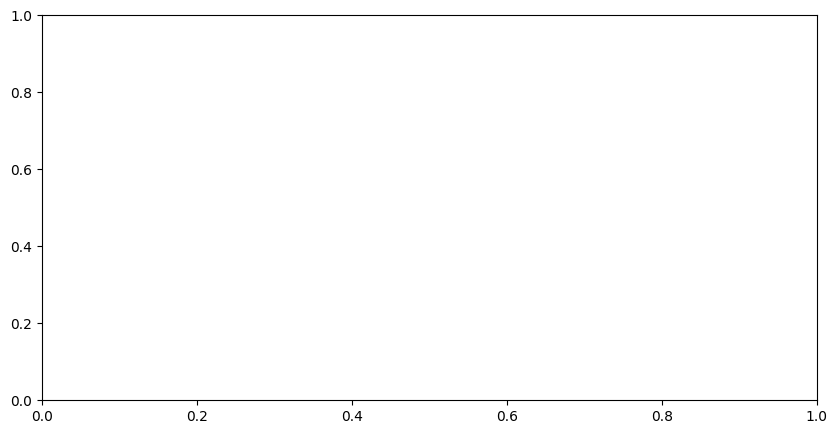

In [28]:
# plot loss history
plt.figure(figsize = (10, 5))
plt.plot(iteration_losses, label = 'Iteration Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [ ]:
sample = np.load('/home/trevor/repos/video_edm2/experiments/mnist_test/samples_027904_99339602063455575688133065481878134393250160843453077890448214290674994981349861913707152312216145464973274376175502395242759439.npy')

In [ ]:
sample.shape

In [ ]:
plt.imshow(sample[0,0,:,:,8])

In [ ]:
import mrcfile

In [ ]:
mrcfile.write('/home/trevor/repos/video_edm2/experiments/mnist_test/samples_027904_99339602.mrc', sample[:8,0], overwrite=True)

In [ ]:
integers = torch.randint(10, size=[5], device=torch.device('cuda'))